<a href="https://colab.research.google.com/github/FrumsM/ML-School-by-REU-Data-Science-Club-Project/blob/main/demo/Store_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание проекта

Проект представляет собой соревнование Kaggle: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview

Цель проекта - прогнозирование продаж в магазине (sales) на основе данных **Corporación Favorita**, крупного эквадорского розничного продавца продуктов питания.

Описание датасетов:

*   df_train - тренировочный датасет;
*   df_test - тестовый датасет;
*   submission - образец файла отправки в правильном формате;
*   oil - Ежедневная цена на нефть. Включает значения как во время обучения, так и во время тестовых данных. (Эквадор — страна, зависящая от нефти, и ее экономическое здоровье очень уязвимо к скачкам цен на нефть.);
*   holidays_events - праздники и мероприятия;
*   stores - магазины;
*   transactions - транзакции.


Метрика: RMSLE


# Установка и импортирование библиотек

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from datetime import datetime, timedelta
from matplotlib.ticker import FuncFormatter

# Загрузка датасетов

In [ ]:
drive.mount('/content/drive')
path1 = '/content/drive/My Drive/sales_test.csv'
path2 = '/content/drive/My Drive/sales_train.csv'
path3 = '/content/drive/My Drive/sales_sub.csv'
path4 = '/content/drive/My Drive/oil.csv'
path5 = '/content/drive/My Drive/stores.csv'
path6 = '/content/drive/My Drive/transactions.csv'
path7 = '/content/drive/My Drive/holidays_events.csv'
df_test = pd.read_csv(path1)
df_train = pd.read_csv(path2)
submission = pd.read_csv(path3)
oil = pd.read_csv(path4)
stores = pd.read_csv(path5)
transactions = pd.read_csv(path6)
holidays_events = pd.read_csv(path7)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_test.sample(5)

,id,date,store_nbr,family,onpromotion
16955,3017843,2017-08-25,34,PET SUPPLIES,0
4813,3005701,2017-08-18,43,POULTRY,14
14480,3015368,2017-08-24,15,PET SUPPLIES,0
11524,3012412,2017-08-22,32,CLEANING,13
11893,3012781,2017-08-22,42,GROCERY II,0


In [ ]:
df_train.sample(5)

,id,date,store_nbr,family,sales,onpromotion
2440048,2440048,2016-10-04,22,POULTRY,230.32,1
2920906,2920906,2017-07-02,15,EGGS,92.00,1
91366,91366,2013-02-21,22,"LIQUOR,WINE,BEER",0.00,0
2738337,2738337,2017-03-21,41,PRODUCE,1407.89,1
1854278,1854278,2015-11-09,37,DAIRY,977.00,1


In [ ]:
submission.sample(5)

,id,sales
26684,3027572,0.00
25122,3026010,0.00
18808,3019696,0.00
20163,3021051,0.00
3673,3004561,0.00


In [ ]:
oil.sample(5)

,date,dcoilwtico
160,2013-08-13,106.78
25,2013-02-05,96.68
7,2013-01-10,93.81
662,2015-07-16,50.90
113,2013-06-07,96.11


In [ ]:
stores.sample(5)

,store_nbr,city,state,type,cluster
38,39,Cuenca,Azuay,B,6
29,30,Guayaquil,Guayas,C,3
39,40,Machala,El Oro,C,3
51,52,Manta,Manabi,A,11
0,1,Quito,Pichincha,D,13


In [ ]:
transactions.sample(5)

,date,store_nbr,transactions
79440,2017-06-02,3,3484
67792,2016-10-23,10,841
70453,2016-12-13,17,1488
60178,2016-05-30,1,1724
56206,2016-03-16,2,1917


In [ ]:
holidays_events.sample(5)

,date,type,locale,locale_name,description,transferred
160,2015-01-02,Bridge,National,Ecuador,Puente Primer dia del ano,False
96,2014-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
52,2013-05-01,Holiday,National,Ecuador,Dia del Trabajo,False
312,2017-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
33,2012-12-22,Additional,National,Ecuador,Navidad-3,False


# Предобработка датасета "holidays_events"

В датасете "holidays_events" присутствует колонка "transfered", которая показывает был ли перенесен праздник. Перенесенный праздник официально приходится на этот календарный день, но правительство перенесло его на другую дату. Перенесенный день больше похож на обычный день, чем на праздник. Для начала посчитаем кол-во перенесенных праздников и общее кол-во строк 

In [ ]:
transferred = (holidays_events['transferred'] == True).sum()
print("Кол-во перенесенных праздников:", transferred)
print("Кол-во строк:", len(holidays_events))

Кол-во перенесенных праздников: 12
Кол-во строк: 350


Удалим перенесенные дни, так как они являются обычными

In [ ]:
holidays_events = holidays_events[holidays_events['transferred'] != True]
holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         338 non-null    object
 1   type         338 non-null    object
 2   locale       338 non-null    object
 3   locale_name  338 non-null    object
 4   description  338 non-null    object
 5   transferred  338 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 16.2+ KB


Найдем дубликаты

In [ ]:
duplicates = holidays_events[holidays_events.duplicated(subset=['date'], keep=False)]
duplicates.sample(5)

,date,type,locale,locale_name,description,transferred
236,2016-05-01,Event,National,Ecuador,Terremoto Manabi+15,False
176,2015-06-25,Holiday,Local,Machala,Fundacion de Machala,False
54,2013-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
259,2016-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
316,2017-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False


Удалим дубликаты из датасета "holidays_events"

In [ ]:
holidays_events = holidays_events.drop_duplicates(subset=['date'], keep='first')

Удалим лишние столбцы

In [ ]:
drop_columns = ['transferred', 'description', 'locale', 'locale_name']
holidays_events = holidays_events.drop(columns=drop_columns)

In [ ]:
holidays_events['type'].value_counts()

Holiday       187
Event          49
Additional     45
Transfer       10
Bridge          5
Work Day        4
Name: type, dtype: int64

Пока что поменяем строки с типом праздника "Work Day" на NaN 

In [ ]:
holidays_events.loc[holidays_events['type'] == 'Work Day', 'type'] = np.nan

In [ ]:
holidays_events['type'].value_counts()

Holiday       187
Event          49
Additional     45
Transfer       10
Bridge          5
Name: type, dtype: int64

In [ ]:
holidays_events.sample(5)

,date,type
92,2014-01-01,Holiday
94,2014-03-03,Holiday
127,2014-07-24,Additional
276,2016-11-03,Holiday
249,2016-05-12,Holiday


# Предобработка датасета "stores"

Предообработуем датасет "stores", добавив 2 признака

In [ ]:
stores.sample(5)

,store_nbr,city,state,type,cluster
28,29,Guayaquil,Guayas,E,10
11,12,Latacunga,Cotopaxi,C,15
46,47,Quito,Pichincha,A,14
26,27,Daule,Guayas,D,1
21,22,Puyo,Pastaza,C,7


Создадим признак store_unique, показывающий 1 если магазин единственный в городе

In [ ]:
stores['store_unique'] = stores['city'].apply(lambda x: 0 if x in ['Quito', 'Guayaquil', 'Santo Domingo', 'Cuenca', 'Manta', 'Machala', 'Latacunga', 'Ambato'] else 1)

Создадим признак "newstore", показывающий 1 если магазмн новый

In [ ]:
stores['newstore'] = stores['store_nbr'].apply(lambda x: 1 if x in [19, 20, 21, 28, 35, 41, 51, 52] else 0)

In [ ]:
stores = stores.rename(columns={'type' : 'store_type'}) 

In [ ]:
stores.sample(5)

,store_nbr,city,state,store_type,cluster,store_unique,newstore
26,27,Daule,Guayas,D,1,1,0
43,44,Quito,Pichincha,A,5,0,0
23,24,Guayaquil,Guayas,D,1,0,0
21,22,Puyo,Pastaza,C,7,1,0
10,11,Cayambe,Pichincha,B,6,1,0


# Объединение датасетов

In [ ]:
df_test_merge = df_test \
  .merge(holidays_events, how = 'left', on = ['date']).rename(columns={'type':'holiday_type'}) \
  .merge(stores, how = 'left', on = ['store_nbr']) \
  .merge(transactions, how = 'left', on = ['date','store_nbr']) \
  .merge(oil, how = 'left', on = ['date'])

In [ ]:
df_merge = df_train \
  .merge(holidays_events, how = 'left', on = ['date']).rename(columns={'type':'holiday_type'}) \
  .merge(stores, how = 'left', on = ['store_nbr']) \
  .merge(transactions, how = 'left', on = ['store_nbr','date']) \
  .merge(oil, how = 'left', on = ['date'] )

In [ ]:
df_merge['id'] = 0
df_merge.sample(5)

,id,date,store_nbr,family,sales,onpromotion,holiday_type,city,state,store_type,cluster,store_unique,newstore,transactions,dcoilwtico
853814,0,2014-04-26,16,BREAD/BAKERY,188.00,0,NaN,Santo Domingo,Santo Domingo de los Tsachilas,C,3,0,0,964.00,NaN
2799526,0,2017-04-25,1,BOOKS,0.00,0,NaN,Quito,Pichincha,D,13,0,0,1732.00,49.22
1673856,0,2015-07-31,24,PRODUCE,3775.14,0,NaN,Guayaquil,Guayas,D,1,0,0,2553.00,47.11
530568,0,2013-10-25,45,PLAYERS AND ELECTRONICS,0.00,0,NaN,Quito,Pichincha,A,11,0,0,3254.00,97.40
1013400,0,2014-07-24,43,BEVERAGES,1991.00,3,Additional,Esmeraldas,Esmeraldas,E,10,1,0,1039.00,102.76


# Анализ датасета

In [ ]:
df_merge.rename(columns={'dcoilwtico': 'oil_price'}, inplace=True)

In [ ]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 15 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            int64  
 1   date          object 
 2   store_nbr     int64  
 3   family        object 
 4   sales         float64
 5   onpromotion   int64  
 6   holiday_type  object 
 7   city          object 
 8   state         object 
 9   store_type    object 
 10  cluster       int64  
 11  store_unique  int64  
 12  newstore      int64  
 13  transactions  float64
 14  oil_price     float64
dtypes: float64(3), int64(6), object(6)
memory usage: 366.3+ MB


Описание датасета:

*   id - id;
*   date - дата;
*   stores - магазины, в которых продаются товары;
*   family - тип продаваевого продукта;
*   sales - общий объем продаж для типов продаваемых продуктов в конкретном магазине;
*   onpromotion - общее кол-во товаров в семействе продуктов, которые рекламировались за определенную дату;
*   holiday_type - тип праздничного дня;
*   city - город;
*   state - провинция Эквадора;
*   city_type - тип города;
*   cluster - группа подобных магазинов;
*   store_unique - уникальность магазина;
*   newstore - новые магазины;
*   transactions - кол-во транзакций;
*   oil_price - дневная цена на нефть.
















In [ ]:
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
df_merge.describe()

,id,store_nbr,sales,onpromotion,cluster,store_unique,newstore,transactions,oil_price
count,3000888.00,3000888.00,3000888.00,3000888.00,3000888.00,3000888.00,3000888.00,2755104.00,2072466.00
mean,0.00,27.50,357.78,2.60,8.48,0.26,0.15,1694.60,67.93
std,0.00,15.59,1102.00,12.22,4.65,0.44,0.36,963.28,25.67
min,0.00,1.00,0.00,0.00,1.00,0.00,0.00,5.00,26.19
25%,0.00,14.00,0.00,0.00,4.00,0.00,0.00,1046.00,46.38
50%,0.00,27.50,11.00,0.00,8.50,0.00,0.00,1393.00,53.33
75%,0.00,41.00,195.85,0.00,13.00,1.00,0.00,2079.00,95.80
max,0.00,54.00,124717.00,741.00,17.00,1.00,1.00,8359.00,110.62


In [ ]:
df_merge.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
holiday_type    2574990
city                  0
state                 0
store_type            0
cluster               0
store_unique          0
newstore              0
transactions     245784
oil_price        928422
dtype: int64

# Предобработка данных и EDA

In [ ]:
df_merge.sample(5)

,id,date,store_nbr,family,sales,onpromotion,holiday_type,city,state,store_type,cluster,store_unique,newstore,transactions,oil_price
2539753,0,2016-11-29,20,CLEANING,760.00,12,NaN,Quito,Pichincha,B,6,0,1,1171.00,45.29
2797765,0,2017-04-24,1,PERSONAL CARE,120.00,6,NaN,Quito,Pichincha,D,13,0,0,1632.00,48.90
2740060,0,2017-03-22,40,BOOKS,0.00,0,NaN,Machala,El Oro,C,3,0,0,1136.00,47.29
1000520,0,2014-07-17,31,PET SUPPLIES,1.00,0,NaN,Babahoyo,Los Rios,B,10,1,0,1221.00,103.84
2664082,0,2017-02-07,9,PERSONAL CARE,435.00,12,NaN,Quito,Pichincha,B,6,0,0,2149.00,52.19


В столбце "holiday_type" много значений NaN, так как в какие-то дни праздников не было. Пока что заменим все пустые ячейки, связанные с праздниками на 'No holiday'

In [ ]:
df_merge['holiday_type'] = df_merge['holiday_type'].fillna('No holiday')

In [ ]:
df_merge.sample(5)

,id,date,store_nbr,family,sales,onpromotion,holiday_type,city,state,store_type,cluster,store_unique,newstore,transactions,oil_price
1872261,0,2015-11-19,41,CELEBRATION,12.00,0,No holiday,Machala,El Oro,D,4,0,1,921.00,40.55
2472492,0,2016-10-22,33,AUTOMOTIVE,16.00,0,No holiday,Quevedo,Los Rios,C,3,1,0,971.00,NaN
1542889,0,2015-05-18,5,CLEANING,975.00,3,No holiday,Santo Domingo,Santo Domingo de los Tsachilas,D,4,0,0,1469.00,59.44
842242,0,2014-04-19,40,HOME AND KITCHEN II,0.00,0,No holiday,Machala,El Oro,C,3,0,0,1291.00,NaN
289859,0,2013-06-12,41,LAWN AND GARDEN,4.00,0,No holiday,Machala,El Oro,D,4,0,1,738.00,95.98


In [ ]:
df_merge.isnull().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
holiday_type         0
city                 0
state                0
store_type           0
cluster              0
store_unique         0
newstore             0
transactions    245784
oil_price       928422
dtype: int64

In [ ]:
df_merge[df_merge['transactions'].isnull()].sample(5)

,id,date,store_nbr,family,sales,onpromotion,holiday_type,city,state,store_type,cluster,store_unique,newstore,transactions,oil_price
1199761,0,2014-11-06,22,GROCERY II,0.00,0,Holiday,Puyo,Pastaza,C,7,1,0,NaN,77.87
1199771,0,2014-11-06,22,MAGAZINES,0.00,0,Holiday,Puyo,Pastaza,C,7,1,0,NaN,77.87
807702,0,2014-03-31,21,PLAYERS AND ELECTRONICS,0.00,0,No holiday,Santo Domingo,Santo Domingo de los Tsachilas,B,6,0,1,NaN,101.57
1217816,0,2014-11-16,29,HOME APPLIANCES,0.00,0,No holiday,Guayaquil,Guayas,E,10,0,0,NaN,NaN
584990,0,2013-11-25,22,SEAFOOD,0.00,0,No holiday,Puyo,Pastaza,C,7,1,0,NaN,93.86


Пустые ячейки в "transactions" связаны с тем, что в определнный день определенные типы продуктов не продавались. Пока что заменим все пустые ячейки на 0

In [ ]:
df_merge['transactions'] = df_merge['transactions'].fillna(0)

In [ ]:
df_merge.isnull().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
holiday_type         0
city                 0
state                0
store_type           0
cluster              0
store_unique         0
newstore             0
transactions         0
oil_price       928422
dtype: int64

In [ ]:
df_merge[df_merge['oil_price'].isnull()].sample(5)

,id,date,store_nbr,family,sales,onpromotion,holiday_type,city,state,store_type,cluster,store_unique,newstore,transactions,oil_price
458720,0,2013-09-15,3,LAWN AND GARDEN,16.00,0,No holiday,Quito,Pichincha,D,8,0,0,3654.00,NaN
1017634,0,2014-07-27,12,GROCERY II,1.00,0,No holiday,Latacunga,Cotopaxi,C,15,0,0,1095.00,NaN
1090707,0,2014-09-06,12,MEATS,146.14,0,No holiday,Latacunga,Cotopaxi,C,15,0,0,1334.00,NaN
469396,0,2013-09-21,3,BOOKS,0.00,0,No holiday,Quito,Pichincha,D,8,0,0,3754.00,NaN
1627260,0,2015-07-05,17,PRODUCE,1269.20,0,No holiday,Quito,Pichincha,C,12,0,0,1396.00,NaN


Займемся отсутствующими значениями цен на нефть. Для начала разобъем столбец "date" на 3 части

In [ ]:
df_merge['date'] = pd.to_datetime(df_merge['date'])
df_merge['year'] = df_merge['date'].dt.year
df_merge['month'] = df_merge['date'].dt.month
df_merge['day'] = df_merge['date'].dt.day

Построим график, отражающий как изменялась цена на нефть каждые пол года и дополнительно зададим линию тренда

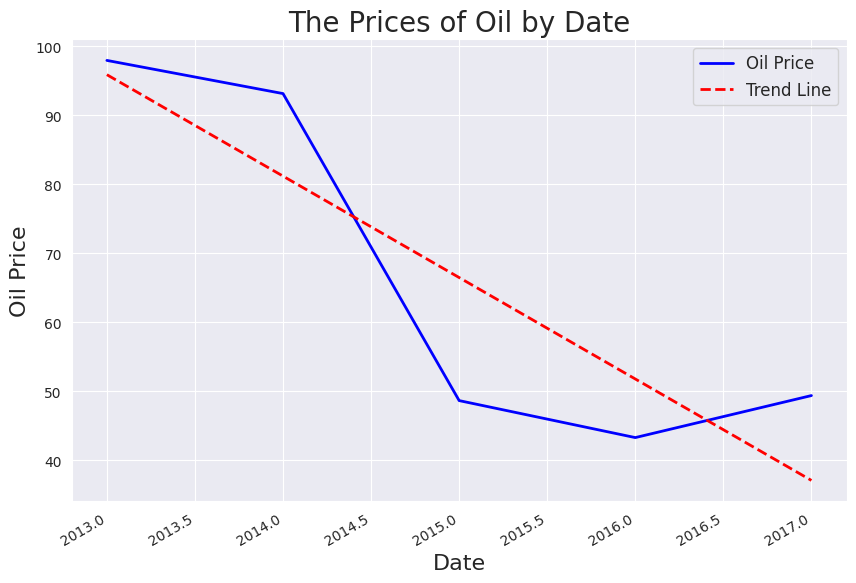

In [ ]:
df_grouped = df_merge.groupby('year')['oil_price'].mean().reset_index()
sns.set_style("darkgrid")  
plt.figure(figsize=(10, 6))  

plt.plot(df_grouped['year'], df_grouped['oil_price'], linestyle='-', color='blue', linewidth=2)

plt.title('The Prices of Oil by Date', fontsize = 20)
plt.xticks(rotation=30, ha='right')
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Oil Price', fontsize = 16)

coefs = np.polyfit(df_grouped['year'], df_grouped['oil_price'], deg=1) # Подбор полиномиальной функции ("deg=1" указывает на линейную функцию)
poly_func = np.poly1d(coefs) # Создание полиномиальной функции
trend_line = poly_func(df_grouped['year']) # Вычисление значений линии тренда
plt.plot(df_grouped['year'], trend_line, linestyle='--', color='red', linewidth=2)

plt.legend(['Oil Price', 'Trend Line'], loc='best', fontsize=12)

plt.grid(True)
plt.show()

Как видно на графике выше, во-первых, тренд на нефть падает, во-вторых, мы можем разделить график цен на нефть на три фазы:  

*   Начало 2013 - начало 2014
*   Начало 2015 - начало 2017
*   Начало 2014 - начало 2015


Первые 2 отрезка времени демонстрируют стабильные тренды с подъемами и падениями. Однако на втором этапе, с 2014 г. по 2015 г., цена на нефть значительно снижается.

Теперь же, заменим отсутствующие значения цены на нефть методом обратного заполнения. Это означает заполнение пропущенных значений следующей точкой данных.

In [ ]:
df_merge['oil_price'] = df_merge['oil_price'].fillna(method='bfill')
df_merge.isnull().sum()

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
holiday_type    0
city            0
state           0
store_type      0
cluster         0
store_unique    0
newstore        0
transactions    0
oil_price       0
year            0
month           0
day             0
dtype: int64

In [ ]:
df_merge.sample(5)

,id,date,store_nbr,family,sales,onpromotion,holiday_type,city,state,store_type,cluster,store_unique,newstore,transactions,oil_price,year,month,day
453911,0,2013-09-12,44,PREPARED FOODS,322.21,0,No holiday,Quito,Pichincha,A,5,0,0,3509.00,108.72,2013,9,12
332255,0,2013-07-06,31,FROZEN FOODS,38.00,0,No holiday,Babahoyo,Los Rios,B,10,1,0,1569.00,103.03,2013,7,6
1240387,0,2014-11-29,12,HOME AND KITCHEN II,11.00,0,No holiday,Latacunga,Cotopaxi,C,15,0,0,1319.00,68.98,2014,11,29
901175,0,2014-05-22,44,FROZEN FOODS,347.61,0,No holiday,Quito,Pichincha,A,5,0,0,3769.00,104.03,2014,5,22
2969608,0,2017-07-29,31,BOOKS,0.00,0,No holiday,Babahoyo,Los Rios,B,10,1,0,1483.00,50.21,2017,7,29


Посмотрим на кол-во выбросов столбца "transactions"

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2c98eafe20>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2c98eade70>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2c98eaca30>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2c98eae2f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2c98eaf640>],
 'means': []}

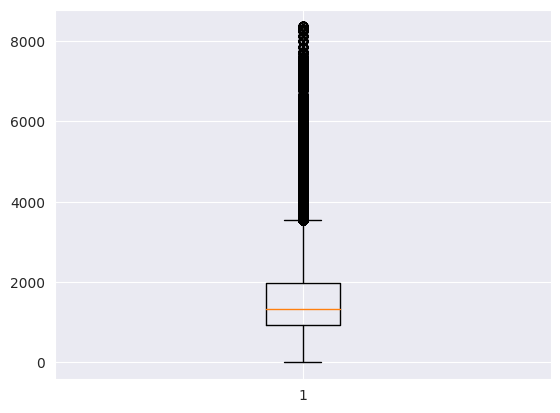

In [ ]:
plt.boxplot(x=df_merge['transactions'])

Можно заметить огромное кол-во выбросов. Посмотрим на них

Для начала посчитаем с какого значения идут выбросы

In [ ]:
q3 = np.quantile(df_merge['transactions'], 0.75)
iqr = np.subtract(*np.percentile(df_merge['transactions'], [75, 25]))

# Вычисление верхнего уса
upper_whisker = q3 + 1.5 * iqr

print(upper_whisker)

3545.625


Посмотрим на выбросы

In [ ]:
df_merge.loc[df_merge['transactions']>3545]

,id,date,store_nbr,family,sales,onpromotion,holiday_type,city,state,store_type,cluster,store_unique,newstore,transactions,oil_price,year,month,day
1848,0,2013-01-02,11,AUTOMOTIVE,12.00,0,No holiday,Cayambe,Pichincha,B,6,1,0,3547.00,93.14,2013,1,2
1849,0,2013-01-02,11,BABY CARE,0.00,0,No holiday,Cayambe,Pichincha,B,6,1,0,3547.00,93.14,2013,1,2
1850,0,2013-01-02,11,BEAUTY,7.00,0,No holiday,Cayambe,Pichincha,B,6,1,0,3547.00,93.14,2013,1,2
1851,0,2013-01-02,11,BEVERAGES,3443.00,0,No holiday,Cayambe,Pichincha,B,6,1,0,3547.00,93.14,2013,1,2
1852,0,2013-01-02,11,BOOKS,0.00,0,No holiday,Cayambe,Pichincha,B,6,1,0,3547.00,93.14,2013,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000487,0,2017-08-15,47,POULTRY,960.40,0,Holiday,Quito,Pichincha,A,14,0,0,3581.00,47.57,2017,8,15
3000488,0,2017-08-15,47,PREPARED FOODS,277.03,0,Holiday,Quito,Pichincha,A,14,0,0,3581.00,47.57,2017,8,15
3000489,0,2017-08-15,47,PRODUCE,5146.25,10,Holiday,Quito,Pichincha,A,14,0,0,3581.00,47.57,2017,8,15
3000490,0,2017-08-15,47,SCHOOL AND OFFICE SUPPLIES,351.00,12,Holiday,Quito,Pichincha,A,14,0,0,3581.00,47.57,2017,8,15


В некоторые дни проводились праздники. Создадим признак "holiday", который будет показывать 1, если есть праздник

In [ ]:
df_merge['holiday'] = df_merge['holiday_type'].apply(lambda x: 1 if x != 'No holiday' else 0)

In [ ]:
df_merge.sample(5)

,id,date,store_nbr,family,sales,onpromotion,holiday_type,city,state,store_type,cluster,store_unique,newstore,transactions,oil_price,year,month,day,holiday
1024721,0,2014-07-31,11,BREAD/BAKERY,609.00,0,No holiday,Cayambe,Pichincha,B,6,1,0,2321.00,98.23,2014,7,31,0
706529,0,2014-02-02,32,SEAFOOD,3.00,0,No holiday,Guayaquil,Guayas,C,3,0,0,694.00,96.44,2014,2,2,0
371835,0,2013-07-28,41,MEATS,194.96,0,No holiday,Machala,El Oro,D,4,0,1,1174.00,104.61,2013,7,28,0
1984883,0,2016-01-22,50,SEAFOOD,12.00,3,No holiday,Ambato,Tungurahua,A,14,0,0,2192.00,32.07,2016,1,22,0
1904729,0,2015-12-07,52,BEAUTY,0.00,0,No holiday,Manta,Manabi,A,11,0,1,0.00,37.64,2015,12,7,0


In [ ]:
df_merge.loc[(df_merge['transactions'] > 3545) & (df_merge['holiday'] == 0)]

,id,date,store_nbr,family,sales,onpromotion,holiday_type,city,state,store_type,cluster,store_unique,newstore,transactions,oil_price,year,month,day,holiday
1848,0,2013-01-02,11,AUTOMOTIVE,12.00,0,No holiday,Cayambe,Pichincha,B,6,1,0,3547.00,93.14,2013,1,2,0
1849,0,2013-01-02,11,BABY CARE,0.00,0,No holiday,Cayambe,Pichincha,B,6,1,0,3547.00,93.14,2013,1,2,0
1850,0,2013-01-02,11,BEAUTY,7.00,0,No holiday,Cayambe,Pichincha,B,6,1,0,3547.00,93.14,2013,1,2,0
1851,0,2013-01-02,11,BEVERAGES,3443.00,0,No holiday,Cayambe,Pichincha,B,6,1,0,3547.00,93.14,2013,1,2,0
1852,0,2013-01-02,11,BOOKS,0.00,0,No holiday,Cayambe,Pichincha,B,6,1,0,3547.00,93.14,2013,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2998705,0,2017-08-14,47,POULTRY,1105.99,0,No holiday,Quito,Pichincha,A,14,0,0,3606.00,47.59,2017,8,14,0
2998706,0,2017-08-14,47,PREPARED FOODS,247.69,0,No holiday,Quito,Pichincha,A,14,0,0,3606.00,47.59,2017,8,14,0
2998707,0,2017-08-14,47,PRODUCE,5660.06,9,No holiday,Quito,Pichincha,A,14,0,0,3606.00,47.59,2017,8,14,0
2998708,0,2017-08-14,47,SCHOOL AND OFFICE SUPPLIES,265.00,12,No holiday,Quito,Pichincha,A,14,0,0,3606.00,47.59,2017,8,14,0


Создадим новый признак "shopping_day", показывающий 1 в выходные дни и пятницу (на эти дни приходится больше всего продаж)

In [ ]:
df_merge["shopping_day"] = (df_merge.date.dt.weekday // 4).astype("int8")

In [ ]:
df_merge.sample(5)

,id,date,store_nbr,family,sales,onpromotion,holiday_type,city,state,store_type,cluster,store_unique,newstore,transactions,oil_price,year,month,day,holiday,shopping_day
2773276,0,2017-04-10,22,"LIQUOR,WINE,BEER",28.00,0,No holiday,Puyo,Pastaza,C,7,1,0,837.00,53.06,2017,4,10,0,0
1898962,0,2015-12-04,40,EGGS,117.00,0,No holiday,Machala,El Oro,C,3,0,0,1289.00,40.00,2015,12,4,0,1
2570558,0,2016-12-16,34,MAGAZINES,0.00,0,No holiday,Guayaquil,Guayas,B,6,0,0,2505.00,51.93,2016,12,16,0,1
2201499,0,2016-05-23,3,BEVERAGES,7311.00,11,No holiday,Quito,Pichincha,D,8,0,0,2926.00,48.12,2016,5,23,0,0
1436741,0,2015-03-20,21,LAWN AND GARDEN,0.00,0,No holiday,Santo Domingo,Santo Domingo de los Tsachilas,B,6,0,1,0.00,46.00,2015,3,20,0,1


In [ ]:
df_merge.loc[(df_merge['transactions'] > 3545) & (df_merge['holiday'] == 0) & (df_merge['shopping_day'] == 0)]

,id,date,store_nbr,family,sales,onpromotion,holiday_type,city,state,store_type,cluster,store_unique,newstore,transactions,oil_price,year,month,day,holiday,shopping_day
1848,0,2013-01-02,11,AUTOMOTIVE,12.00,0,No holiday,Cayambe,Pichincha,B,6,1,0,3547.00,93.14,2013,1,2,0,0
1849,0,2013-01-02,11,BABY CARE,0.00,0,No holiday,Cayambe,Pichincha,B,6,1,0,3547.00,93.14,2013,1,2,0,0
1850,0,2013-01-02,11,BEAUTY,7.00,0,No holiday,Cayambe,Pichincha,B,6,1,0,3547.00,93.14,2013,1,2,0,0
1851,0,2013-01-02,11,BEVERAGES,3443.00,0,No holiday,Cayambe,Pichincha,B,6,1,0,3547.00,93.14,2013,1,2,0,0
1852,0,2013-01-02,11,BOOKS,0.00,0,No holiday,Cayambe,Pichincha,B,6,1,0,3547.00,93.14,2013,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2998705,0,2017-08-14,47,POULTRY,1105.99,0,No holiday,Quito,Pichincha,A,14,0,0,3606.00,47.59,2017,8,14,0,0
2998706,0,2017-08-14,47,PREPARED FOODS,247.69,0,No holiday,Quito,Pichincha,A,14,0,0,3606.00,47.59,2017,8,14,0,0
2998707,0,2017-08-14,47,PRODUCE,5660.06,9,No holiday,Quito,Pichincha,A,14,0,0,3606.00,47.59,2017,8,14,0,0
2998708,0,2017-08-14,47,SCHOOL AND OFFICE SUPPLIES,265.00,12,No holiday,Quito,Pichincha,A,14,0,0,3606.00,47.59,2017,8,14,0,0


Огромное кол-во выбросов связано с днями до и после больших праздников. Логично, что в новогый год много людей пойдет покупать продукты. Добавим в "shopping_day" даты начала и конца года

In [ ]:
df_merge["shopping_day"] = ((df_merge.date.dt.weekday // 4 == 1) | ((df_merge.date.dt.month == 1) & (df_merge.date.dt.day == 2))
| ((df_merge.date.dt.month == 1) & (df_merge.date.dt.day == 3)) | ((df_merge.date.dt.month == 12) & (df_merge.date.dt.day == 30))
| ((df_merge.date.dt.month == 12) & (df_merge.date.dt.day == 29)) | ((df_merge.date.dt.month == 12) & (df_merge.date.dt.day == 28))).astype("int8")

In [ ]:
df_merge.loc[(df_merge['transactions'] > 3545) & (df_merge['holiday'] == 0) & (df_merge['shopping_day'] == 0)]

,id,date,store_nbr,family,sales,onpromotion,holiday_type,city,state,store_type,cluster,store_unique,newstore,transactions,oil_price,year,month,day,holiday,shopping_day
11946,0,2013-01-07,44,AUTOMOTIVE,6.00,0,No holiday,Quito,Pichincha,A,5,0,0,3871.00,93.20,2013,1,7,0,0
11947,0,2013-01-07,44,BABY CARE,0.00,0,No holiday,Quito,Pichincha,A,5,0,0,3871.00,93.20,2013,1,7,0,0
11948,0,2013-01-07,44,BEAUTY,4.00,0,No holiday,Quito,Pichincha,A,5,0,0,3871.00,93.20,2013,1,7,0,0
11949,0,2013-01-07,44,BEVERAGES,4373.00,0,No holiday,Quito,Pichincha,A,5,0,0,3871.00,93.20,2013,1,7,0,0
11950,0,2013-01-07,44,BOOKS,0.00,0,No holiday,Quito,Pichincha,A,5,0,0,3871.00,93.20,2013,1,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2998705,0,2017-08-14,47,POULTRY,1105.99,0,No holiday,Quito,Pichincha,A,14,0,0,3606.00,47.59,2017,8,14,0,0
2998706,0,2017-08-14,47,PREPARED FOODS,247.69,0,No holiday,Quito,Pichincha,A,14,0,0,3606.00,47.59,2017,8,14,0,0
2998707,0,2017-08-14,47,PRODUCE,5660.06,9,No holiday,Quito,Pichincha,A,14,0,0,3606.00,47.59,2017,8,14,0,0
2998708,0,2017-08-14,47,SCHOOL AND OFFICE SUPPLIES,265.00,12,No holiday,Quito,Pichincha,A,14,0,0,3606.00,47.59,2017,8,14,0,0


 Также, в Эквадоре зарплата выплачивается каждые 2 недели (15 число и последний день месяца). Это также может повлиять на кол-во продаж. Введем новый признак payday, который будет показывать 1 в дни, когда люди получают свою зарплату

In [ ]:
df_merge['payday'] = df_merge['date'].apply(lambda x: 1 if x.day == 15 or x.is_month_end else 0)

In [ ]:
df_merge.loc[(df_merge['transactions'] > 3545) & (df_merge['holiday'] == 0) & (df_merge['shopping_day'] == 0) & (df_merge['payday'] == 0)]

,id,date,store_nbr,family,sales,onpromotion,holiday_type,city,state,store_type,...,store_unique,newstore,transactions,oil_price,year,month,day,holiday,shopping_day,payday
11946,0,2013-01-07,44,AUTOMOTIVE,6.00,0,No holiday,Quito,Pichincha,A,...,0,0,3871.00,93.20,2013,1,7,0,0,0
11947,0,2013-01-07,44,BABY CARE,0.00,0,No holiday,Quito,Pichincha,A,...,0,0,3871.00,93.20,2013,1,7,0,0,0
11948,0,2013-01-07,44,BEAUTY,4.00,0,No holiday,Quito,Pichincha,A,...,0,0,3871.00,93.20,2013,1,7,0,0,0
11949,0,2013-01-07,44,BEVERAGES,4373.00,0,No holiday,Quito,Pichincha,A,...,0,0,3871.00,93.20,2013,1,7,0,0,0
11950,0,2013-01-07,44,BOOKS,0.00,0,No holiday,Quito,Pichincha,A,...,0,0,3871.00,93.20,2013,1,7,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2998705,0,2017-08-14,47,POULTRY,1105.99,0,No holiday,Quito,Pichincha,A,...,0,0,3606.00,47.59,2017,8,14,0,0,0
2998706,0,2017-08-14,47,PREPARED FOODS,247.69,0,No holiday,Quito,Pichincha,A,...,0,0,3606.00,47.59,2017,8,14,0,0,0
2998707,0,2017-08-14,47,PRODUCE,5660.06,9,No holiday,Quito,Pichincha,A,...,0,0,3606.00,47.59,2017,8,14,0,0,0
2998708,0,2017-08-14,47,SCHOOL AND OFFICE SUPPLIES,265.00,12,No holiday,Quito,Pichincha,A,...,0,0,3606.00,47.59,2017,8,14,0,0,0


 Создадим признак quarter, состоящих из значений от 1 до 4, отражающих текущий квартал

In [ ]:
df_merge['quarter'] = df_merge['date'].dt.quarter

Посмотрим в какой квартал продаж больше всего

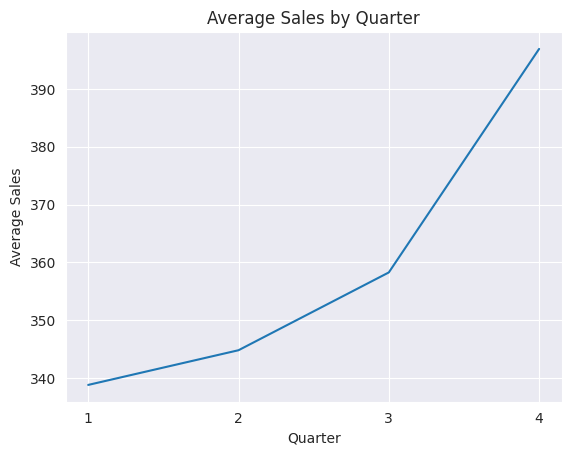

In [ ]:
quarterly_sales = df_merge.groupby('quarter')['sales'].mean()
plt.plot(quarterly_sales.index, quarterly_sales.values)
plt.xlabel('Quarter')
plt.ylabel('Average Sales')
plt.title('Average Sales by Quarter')
plt.xticks(range(1, len(quarterly_sales) + 1), quarterly_sales.index.astype(int))
plt.show()

Можно заметить, что наибольшее среднее кол-во продаж приходится на 4 квартал

Добавим новые временные признаки которые влияют на продажи

In [ ]:
df_merge['is_month_start'] = df_merge.date.dt.is_month_start.astype("int8")
df_merge['is_month_end'] = df_merge.date.dt.is_month_end.astype("int8")
df_merge['is_quarter_start'] = df_merge.date.dt.is_quarter_start.astype("int8")
df_merge['is_quarter_end'] = df_merge.date.dt.is_quarter_end.astype("int8")
df_merge['is_year_start'] = df_merge.date.dt.is_year_start.astype("int8")
df_merge['is_year_end'] = df_merge.date.dt.is_year_end.astype("int8")
# 0: зима; 1: весна; 2: лето; 3: осень
df_merge["season"] = np.where(df_merge.month.isin([12,1,2]), 0, 1)
df_merge["season"] = np.where(df_merge.month.isin([6,7,8]), 2, df_merge["season"])
df_merge["season"] = pd.Series(np.where(df_merge.month.isin([9, 10, 11]), 3, df_merge["season"])).astype("int8")
df_merge.sample(5)

,id,date,store_nbr,family,sales,onpromotion,holiday_type,city,state,store_type,...,shopping_day,payday,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season
2863314,0,2017-05-30,49,BEVERAGES,5965.00,39,No holiday,Quito,Pichincha,A,...,0,0,2,0,0,0,0,0,0,1
1323702,0,2015-01-15,5,CELEBRATION,0.00,0,No holiday,Santo Domingo,Santo Domingo de los Tsachilas,D,...,0,1,1,0,0,0,0,0,0,0
2619373,0,2017-01-13,53,SCHOOL AND OFFICE SUPPLIES,2.00,0,No holiday,Manta,Manabi,D,...,1,0,1,0,0,0,0,0,0,0
1315795,0,2015-01-11,28,LADIESWEAR,0.00,0,No holiday,Guayaquil,Guayas,E,...,1,0,1,0,0,0,0,0,0,0
2000249,0,2016-01-31,32,LAWN AND GARDEN,0.00,0,No holiday,Guayaquil,Guayas,C,...,1,1,1,0,1,0,0,0,0,0


Посмотрим на выбросы

In [ ]:
df_merge.loc[(df_merge['transactions'] > 4800) & (df_merge['holiday'] == 0) & (df_merge['shopping_day'] == 0) & (df_merge['payday'] == 0) & (df_merge['is_month_start'] == 0)
& (df_merge['is_month_end'] == 0) & (df_merge['is_quarter_start'] == 0) & (df_merge['is_quarter_end'] == 0) & (df_merge['is_year_start'] == 0) & (df_merge['is_year_end'] == 0)]

,id,date,store_nbr,family,sales,onpromotion,holiday_type,city,state,store_type,...,shopping_day,payday,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season
614262,0,2013-12-11,44,AUTOMOTIVE,7.00,0,No holiday,Quito,Pichincha,A,...,0,0,4,0,0,0,0,0,0,0
614263,0,2013-12-11,44,BABY CARE,0.00,0,No holiday,Quito,Pichincha,A,...,0,0,4,0,0,0,0,0,0,0
614264,0,2013-12-11,44,BEAUTY,8.00,0,No holiday,Quito,Pichincha,A,...,0,0,4,0,0,0,0,0,0,0
614265,0,2013-12-11,44,BEVERAGES,4031.00,0,No holiday,Quito,Pichincha,A,...,0,0,4,0,0,0,0,0,0,0
614266,0,2013-12-11,44,BOOKS,0.00,0,No holiday,Quito,Pichincha,A,...,0,0,4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2578219,0,2016-12-20,49,POULTRY,1085.14,1,No holiday,Quito,Pichincha,A,...,0,0,4,0,0,0,0,0,0,0
2578220,0,2016-12-20,49,PREPARED FOODS,452.18,2,No holiday,Quito,Pichincha,A,...,0,0,4,0,0,0,0,0,0,0
2578221,0,2016-12-20,49,PRODUCE,8350.25,10,No holiday,Quito,Pichincha,A,...,0,0,4,0,0,0,0,0,0,0
2578222,0,2016-12-20,49,SCHOOL AND OFFICE SUPPLIES,3.00,0,No holiday,Quito,Pichincha,A,...,0,0,4,0,0,0,0,0,0,0


16 апреля 2016 года в Эквадоре прошло сильное землетрясение. Это могло сильно повлиять на продажи в дни после землетрясения. Посмотрим как этот случай затронул продажи. Построим график, отражающий среднее кол-во продаж до и после 3 месяцев с момента землетрясения 

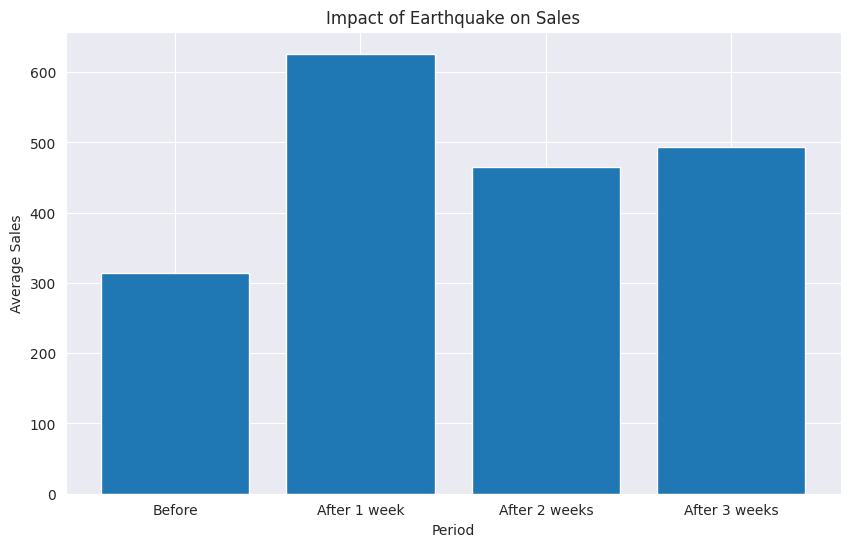

In [ ]:
before_earthquake = df_merge[df_merge['date'] < pd.to_datetime('2016-04-16')]  
after_earthquake_1_month = df_merge[(df_merge['date'] >= pd.to_datetime('2016-04-16')) & (df_merge['date'] < pd.to_datetime('2016-04-22'))]
after_earthquake_2_month = df_merge[(df_merge['date'] >= pd.to_datetime('2016-04-22')) & (df_merge['date'] < pd.to_datetime('2016-04-28'))]
after_earthquake_3_month = df_merge[(df_merge['date'] >= pd.to_datetime('2016-04-28')) & (df_merge['date'] < pd.to_datetime('2016-05-05'))]
average_sales_before = before_earthquake['sales'].mean()
average_sales_after_1_month = after_earthquake_1_month['sales'].mean()
average_sales_after_2_month = after_earthquake_2_month['sales'].mean()
average_sales_after_3_month = after_earthquake_3_month['sales'].mean()

plt.figure(figsize=(10, 6))  
plt.bar(['Before', 'After 1 week', 'After 2 weeks','After 3 weeks'], [average_sales_before, average_sales_after_1_month,average_sales_after_2_month,average_sales_after_3_month])
plt.xlabel('Period')
plt.ylabel('Average Sales')
plt.title('Impact of Earthquake on Sales')
plt.show()

Как можно заметить, продажи подскочили больше чем в полтора раза и даже спустя 3 недели не вернулись к среднему значению. Добавим признак "earthquake", показывающий 1 за 3 недели после землетрясения

In [ ]:
df_merge['earthquake'] = (df_merge['date'] >= '2016-04-16') & (df_merge['date'] <= '2016-05-05')

In [ ]:
df_merge.sample(5)

,id,date,store_nbr,family,sales,onpromotion,holiday_type,city,state,store_type,...,payday,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season,earthquake
1353035,0,2015-02-01,23,BEAUTY,4.00,1,No holiday,Ambato,Tungurahua,D,...,0,1,1,0,0,0,0,0,0,False
385897,0,2013-08-05,36,POULTRY,76.23,0,Holiday,Libertad,Guayas,E,...,0,3,0,0,0,0,0,0,2,False
2207699,0,2016-05-26,52,SEAFOOD,0.00,0,No holiday,Manta,Manabi,A,...,0,2,0,0,0,0,0,0,1,False
2926042,0,2017-07-04,9,SCHOOL AND OFFICE SUPPLIES,2.00,0,No holiday,Quito,Pichincha,B,...,0,3,0,0,0,0,0,0,2,False
408864,0,2013-08-18,30,PLAYERS AND ELECTRONICS,0.00,0,No holiday,Guayaquil,Guayas,C,...,0,3,0,0,0,0,0,0,2,False


Посмотрим на выбросы

In [ ]:
df_merge.loc[(df_merge['transactions'] > 3800) & (df_merge['holiday'] == 0) & (df_merge['shopping_day'] == 0) & (df_merge['payday'] == 0) & (df_merge['is_month_start'] == 0)
& (df_merge['is_month_end'] == 0) & (df_merge['is_quarter_start'] == 0) & (df_merge['is_quarter_end'] == 0) & (df_merge['is_year_start'] == 0) & (df_merge['is_year_end'] == 0)
& (df_merge['earthquake'] == False)]

,id,date,store_nbr,family,sales,onpromotion,holiday_type,city,state,store_type,...,payday,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season,earthquake
11946,0,2013-01-07,44,AUTOMOTIVE,6.00,0,No holiday,Quito,Pichincha,A,...,0,1,0,0,0,0,0,0,0,False
11947,0,2013-01-07,44,BABY CARE,0.00,0,No holiday,Quito,Pichincha,A,...,0,1,0,0,0,0,0,0,0,False
11948,0,2013-01-07,44,BEAUTY,4.00,0,No holiday,Quito,Pichincha,A,...,0,1,0,0,0,0,0,0,0,False
11949,0,2013-01-07,44,BEVERAGES,4373.00,0,No holiday,Quito,Pichincha,A,...,0,1,0,0,0,0,0,0,0,False
11950,0,2013-01-07,44,BOOKS,0.00,0,No holiday,Quito,Pichincha,A,...,0,1,0,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2998606,0,2017-08-14,44,POULTRY,1028.52,0,No holiday,Quito,Pichincha,A,...,0,3,0,0,0,0,0,0,2,False
2998607,0,2017-08-14,44,PREPARED FOODS,297.05,0,No holiday,Quito,Pichincha,A,...,0,3,0,0,0,0,0,0,2,False
2998608,0,2017-08-14,44,PRODUCE,8735.74,10,No holiday,Quito,Pichincha,A,...,0,3,0,0,0,0,0,0,2,False
2998609,0,2017-08-14,44,SCHOOL AND OFFICE SUPPLIES,326.00,12,No holiday,Quito,Pichincha,A,...,0,3,0,0,0,0,0,0,2,False


In [ ]:
emissions = df_merge.loc[(df_merge['holiday'] == 0) & (df_merge['shopping_day'] == 0) & (df_merge['payday'] == 0) & (df_merge['is_month_start'] == 0)
& (df_merge['is_month_end'] == 0) & (df_merge['is_quarter_start'] == 0) & (df_merge['is_quarter_end'] == 0) & (df_merge['is_year_start'] == 0) & (df_merge['is_year_end'] == 0)
& (df_merge['earthquake'] == False)]

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2c95d6ce50>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2c95de26b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2c9903b1f0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2c972f09a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2c972f1060>],
 'means': []}

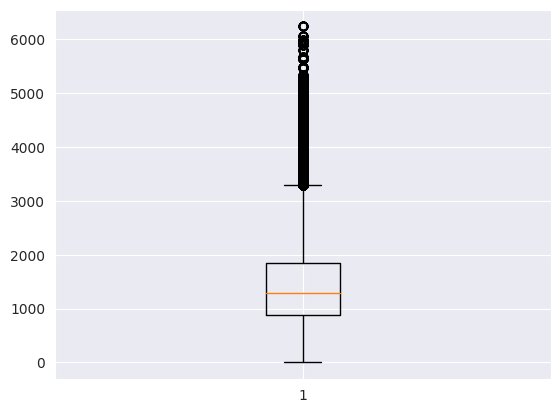

In [ ]:
plt.boxplot(x=emissions['transactions'])

Выбросов стало гораздо меньше

Посчитаем границу верхнего уса

In [ ]:
q3 = np.quantile(emissions['transactions'], 0.75)
iqr = np.subtract(*np.percentile(emissions['transactions'], [75, 25]))

# Вычисление верхнего уса
upper_whisker = q3 + 1.5 * iqr

print(upper_whisker)

3292.5


Удалим остальные выбросы

In [ ]:
df_merge = df_merge.drop(df_merge[df_merge['transactions'] > 3292].index)

Построим график, показывающий самые часто продаваемые типы продукции

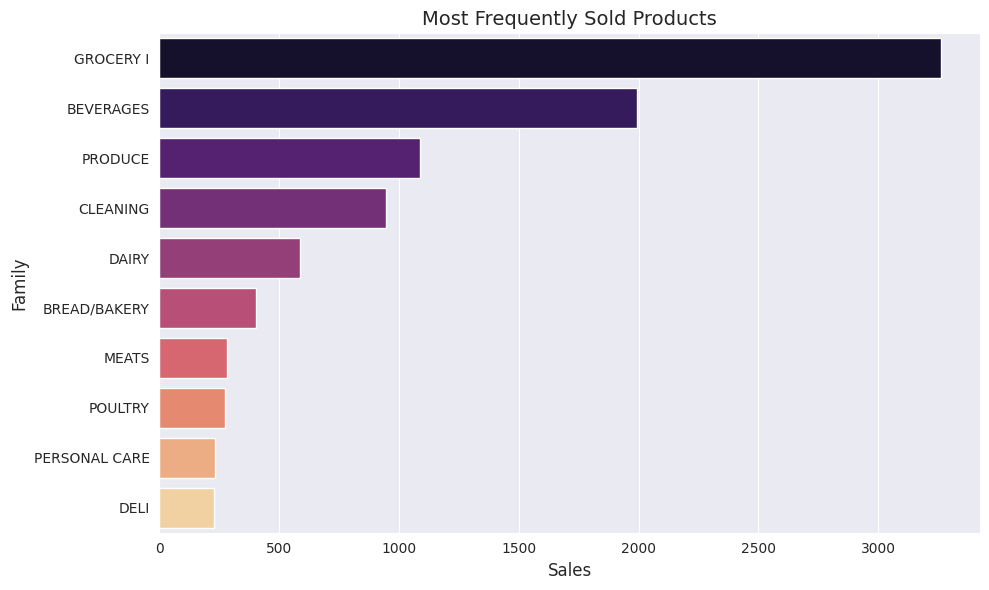

In [ ]:
family = df_merge.groupby('family')['sales'].mean().sort_values(ascending=False).round().to_frame().head(10)
plt.figure(figsize=(10, 6))  
sns.barplot(data=family, x="sales", y=family.index,palette = 'magma')

plt.xlabel('Sales', fontsize=12)
plt.ylabel('Family', fontsize=12)
plt.title('Most Frequently Sold Products', fontsize=14)

plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

**Вывод: с явным отрывом лидируют продукты первой необходимости "Grocery 1" и напитки "Bevergares"**

In [ ]:
df_merge.sample(5)

,id,date,store_nbr,family,sales,onpromotion,holiday_type,city,state,store_type,...,payday,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season,earthquake
1716375,0,2015-08-24,18,GROCERY I,2058.26,3,Holiday,Quito,Pichincha,B,...,0,3,0,0,0,0,0,0,2,False
2340913,0,2016-08-09,40,PERSONAL CARE,322.00,4,No holiday,Machala,El Oro,C,...,0,3,0,0,0,0,0,0,2,False
1233599,0,2014-11-25,21,PET SUPPLIES,0.00,0,No holiday,Santo Domingo,Santo Domingo de los Tsachilas,B,...,0,4,0,0,0,0,0,0,3,False
1939777,0,2015-12-28,36,BOOKS,0.00,0,No holiday,Libertad,Guayas,E,...,0,4,0,0,0,0,0,0,0,False
1289467,0,2014-12-27,39,PERSONAL CARE,409.00,0,No holiday,Cuenca,Azuay,B,...,0,4,0,0,0,0,0,0,0,False


Посмотрим какие типы магазинов преобладают 

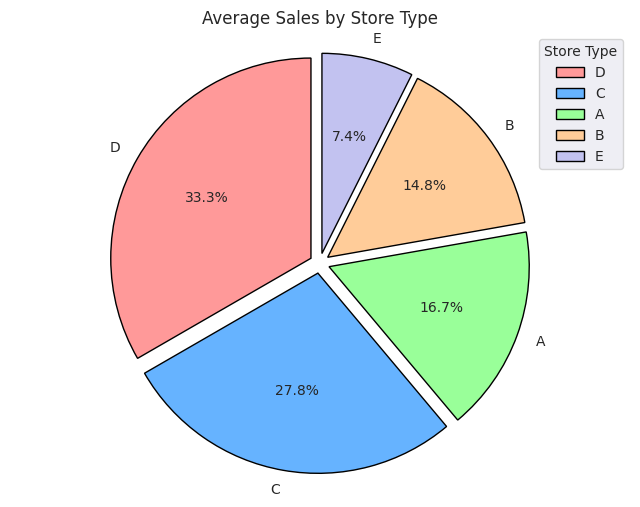

In [ ]:
store_count_by_class = stores['store_type'].value_counts()

# Параметры для круговой диаграммы
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#c2d6d6', '#ffb3b3']
explode = [0.05] * len(store_count_by_class)  # Выделение секторов

plt.figure(figsize=(8, 6))
plt.pie(store_count_by_class, labels=store_count_by_class.index, autopct='%1.1f%%',
        colors=colors, explode=explode, startangle=90, wedgeprops={'edgecolor': 'black'})
plt.axis('equal')

plt.legend(store_count_by_class.index, loc='best', title='Store Type')
plt.title('Average Sales by Store Type')

plt.show()


**Вывод: как можно заметить, больше всего магазинов относится к категории среднего класса**

Посмотрим на средние продажи каждого города

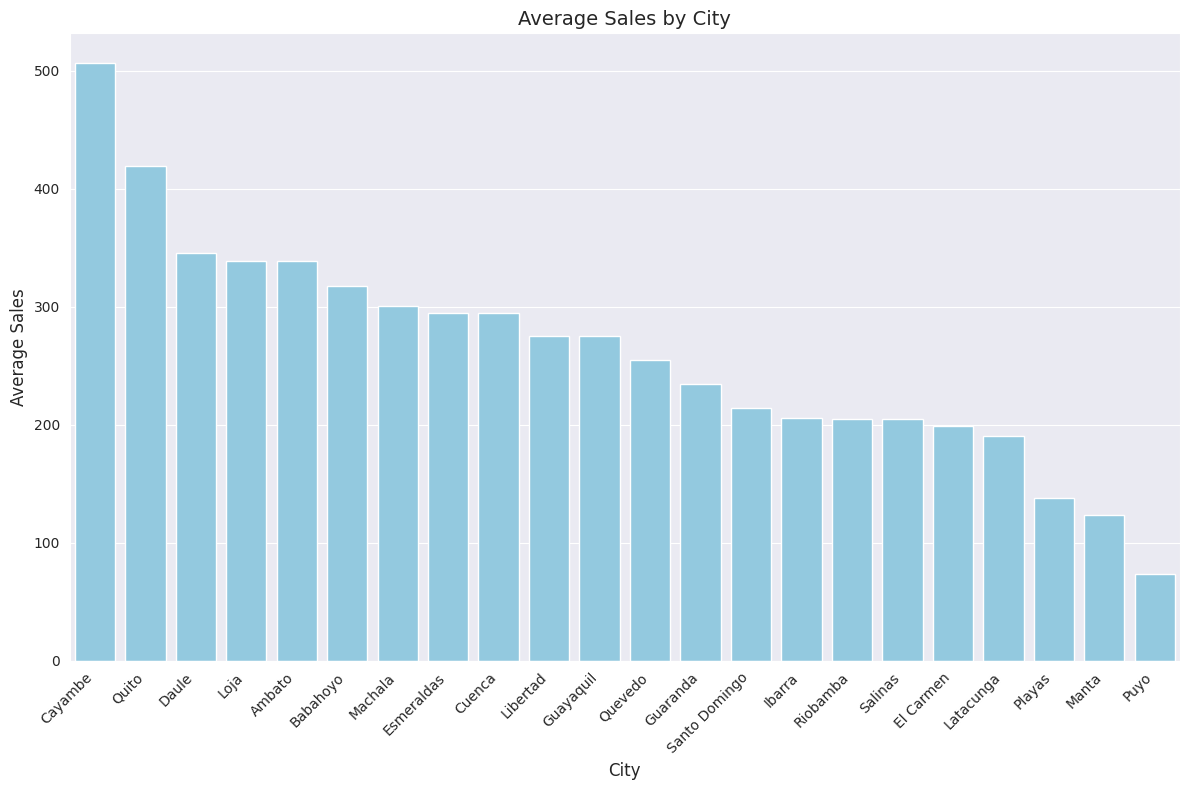

In [ ]:
average_sales_by_city = df_merge.groupby('city')['sales'].mean()
average_sales_by_city = average_sales_by_city.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=average_sales_by_city.index, y=average_sales_by_city, color='skyblue')

plt.xlabel('City', fontsize=12)
plt.ylabel('Average Sales', fontsize=12)
plt.title('Average Sales by City', fontsize=14)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


**Вывод: наибольшее среднее число продаж приходится на город сельскохозяйственных услуг Кайамбе, что довольно удивительно, так как столица Эквадора располагается на 2 месте. Это может быть связано со многими причинами, например:**

1. Различия в плотности населения;
2. Экономические различия;
3. Культурные различия;
4. Маркетинговые стратегии.

Посмотрим в каком городе самый большой объем рекламы

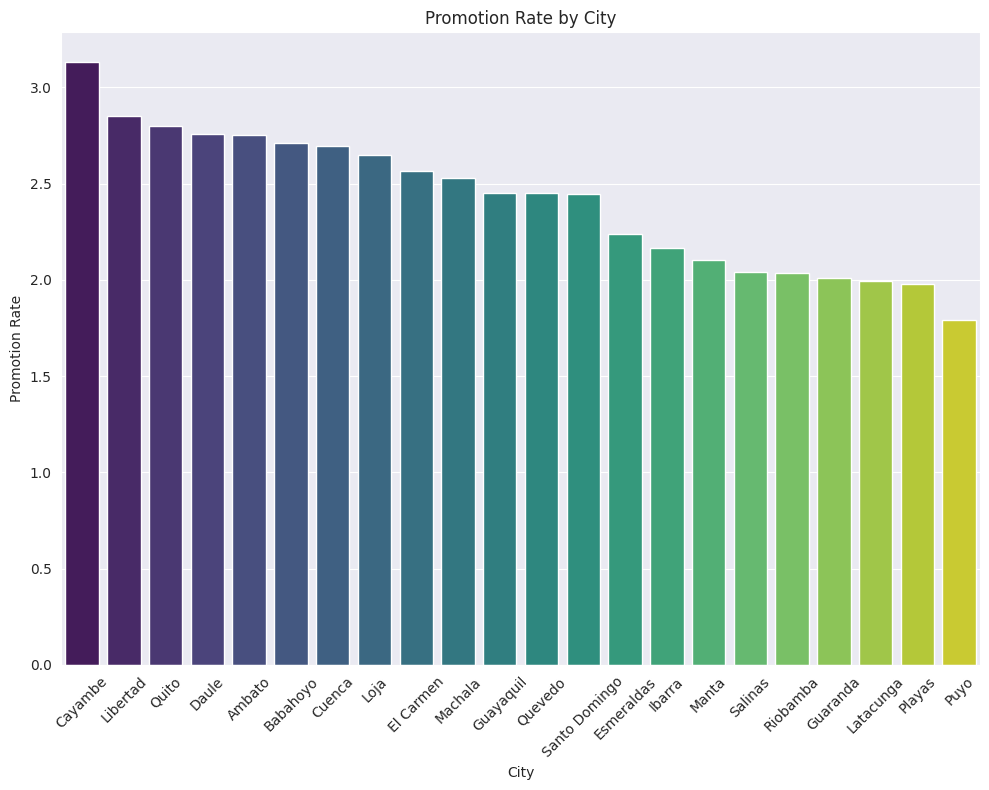

In [ ]:
plt.figure(figsize=(10, 8))
promotion_by_city = df_merge.groupby('city')['onpromotion'].mean().sort_values(ascending=False)
sns.barplot(x=promotion_by_city.index, y=promotion_by_city, palette='viridis')
plt.xlabel('City')
plt.ylabel('Promotion Rate')
plt.title('Promotion Rate by City')

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

**Вывод: можно увидеть что больше всего рекламы товаров приходилось именно на Кайамбе. Это может быть одним из объяснений таких больших продаж. В то же время 2 город по кол-ву рекламы Либертад, находящийся в середине по продажам. Можно сделать вывод, что реклама, проводимая в этом городе неэффективна**

# Преобразование датасета "df_test"

In [ ]:
df_test_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28512 entries, 0 to 28511
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            28512 non-null  int64  
 1   date          28512 non-null  object 
 2   store_nbr     28512 non-null  int64  
 3   family        28512 non-null  object 
 4   onpromotion   28512 non-null  int64  
 5   holiday_type  1782 non-null   object 
 6   city          28512 non-null  object 
 7   state         28512 non-null  object 
 8   store_type    28512 non-null  object 
 9   cluster       28512 non-null  int64  
 10  store_unique  28512 non-null  int64  
 11  newstore      28512 non-null  int64  
 12  transactions  0 non-null      float64
 13  dcoilwtico    21384 non-null  float64
dtypes: float64(2), int64(6), object(6)
memory usage: 3.3+ MB


In [ ]:
df_test_merge.isnull().sum()

id                  0
date                0
store_nbr           0
family              0
onpromotion         0
holiday_type    26730
city                0
state               0
store_type          0
cluster             0
store_unique        0
newstore            0
transactions    28512
dcoilwtico       7128
dtype: int64

In [ ]:
df_test_merge.sample(5)

,id,date,store_nbr,family,onpromotion,holiday_type,city,state,store_type,cluster,store_unique,newstore,transactions,dcoilwtico
23447,3024335,2017-08-29,17,HOME APPLIANCES,0,NaN,Quito,Pichincha,C,12,0,0,NaN,46.46
11220,3012108,2017-08-22,24,AUTOMOTIVE,0,NaN,Guayaquil,Guayas,D,1,0,0,NaN,47.65
5827,3006715,2017-08-19,22,LADIESWEAR,0,NaN,Puyo,Pastaza,C,7,1,0,NaN,NaN
7070,3007958,2017-08-19,8,DAIRY,22,NaN,Quito,Pichincha,D,8,0,0,NaN,NaN
13662,3014550,2017-08-23,42,AUTOMOTIVE,0,NaN,Cuenca,Azuay,D,2,0,0,NaN,48.45


In [ ]:
df_test_merge.rename(columns={'dcoilwtico': 'oil_price'}, inplace=True)
df_test_merge['holiday_type'] = df_test_merge['holiday_type'].fillna('No holiday')
df_test_merge['transactions'] = df_test_merge['transactions'].fillna(0)
df_test_merge['date'] = pd.to_datetime(df_test_merge['date'])
df_test_merge['year'] = df_test_merge['date'].dt.year
df_test_merge['month'] = df_test_merge['date'].dt.month
df_test_merge['day'] = df_test_merge['date'].dt.day
df_test_merge['oil_price'] = df_test_merge['oil_price'].fillna(method='bfill')
df_test_merge['holiday'] = df_test_merge['holiday_type'].apply(lambda x: 1 if x != 'No holiday' else 0)
df_merge["shopping_day"] = ((df_merge.date.dt.weekday // 4 == 1) | ((df_merge.date.dt.month == 1) & (df_merge.date.dt.day == 2))
| ((df_merge.date.dt.month == 1) & (df_merge.date.dt.day == 3)) | ((df_merge.date.dt.month == 12) & (df_merge.date.dt.day == 30))
| ((df_merge.date.dt.month == 12) & (df_merge.date.dt.day == 29)) | ((df_merge.date.dt.month == 12) & (df_merge.date.dt.day == 28))).astype("int8")
df_test_merge['payday'] = df_test_merge['date'].apply(lambda x: 1 if x.day == 15 or x.is_month_end else 0)
df_test_merge['quarter'] = df_test_merge['date'].dt.quarter
df_test_merge['is_month_start'] = df_test_merge.date.dt.is_month_start.astype("int8")
df_test_merge['is_month_end'] = df_test_merge.date.dt.is_month_end.astype("int8")
df_test_merge['is_quarter_start'] = df_test_merge.date.dt.is_quarter_start.astype("int8")
df_test_merge['is_quarter_end'] = df_test_merge.date.dt.is_quarter_end.astype("int8")
df_test_merge['is_year_start'] = df_test_merge.date.dt.is_year_start.astype("int8")
df_test_merge['is_year_end'] = df_test_merge.date.dt.is_year_end.astype("int8")
df_test_merge["season"] = np.where(df_test_merge.month.isin([12,1,2]), 0, 1)
df_test_merge["season"] = np.where(df_test_merge.month.isin([6,7,8]), 2, df_test_merge["season"])
df_test_merge["season"] = pd.Series(np.where(df_test_merge.month.isin([9, 10, 11]), 3, df_test_merge["season"])).astype("int8")
df_test_merge['earthquake'] = (df_test_merge['date'] >= '2016-04-16') & (df_test_merge['date'] <= '2016-05-05')

df_test_merge['family'] = df_test_merge['family'].str.replace(' ', '_').str.replace('/', '_').str.replace(',','_').str.replace('II','II').str.replace('I','I')

df_test_merge.sample(5)

,id,date,store_nbr,family,onpromotion,holiday_type,city,state,store_type,cluster,...,payday,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season,earthquake
26292,3027180,2017-08-30,46,MEATS,0,No holiday,Quito,Pichincha,A,14,...,0,3,0,0,0,0,0,0,2,False
10248,3011136,2017-08-21,46,HOME_CARE,7,No holiday,Quito,Pichincha,A,14,...,0,3,0,0,0,0,0,0,2,False
6157,3007045,2017-08-19,31,LADIESWEAR,0,No holiday,Babahoyo,Los Rios,B,10,...,0,3,0,0,0,0,0,0,2,False
4980,3005868,2017-08-18,48,PRODUCE,4,No holiday,Quito,Pichincha,A,14,...,0,3,0,0,0,0,0,0,2,False
19502,3020390,2017-08-26,6,SEAFOOD,1,No holiday,Quito,Pichincha,D,13,...,0,3,0,0,0,0,0,0,2,False


In [ ]:
df_test_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28512 entries, 0 to 28511
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                28512 non-null  int64         
 1   date              28512 non-null  datetime64[ns]
 2   store_nbr         28512 non-null  int64         
 3   family            28512 non-null  object        
 4   onpromotion       28512 non-null  int64         
 5   holiday_type      28512 non-null  object        
 6   city              28512 non-null  object        
 7   state             28512 non-null  object        
 8   store_type        28512 non-null  object        
 9   cluster           28512 non-null  int64         
 10  store_unique      28512 non-null  int64         
 11  newstore          28512 non-null  int64         
 12  transactions      28512 non-null  float64       
 13  oil_price         28512 non-null  float64       
 14  year              2851

# Кодировка признаков

In [ ]:
df_merge['family'] = df_merge['family'].str.replace(' ', '_').str.replace('/', '_').str.replace(',','_').str.replace('II','II').str.replace('I','I')

Закодируем с помощью LabelEncoder признаки типа object:

In [ ]:
label_encoder = LabelEncoder()
df_combined = pd.concat([df_merge, df_test_merge], axis=0)

non_numerical_cols =  [col for col in df_combined.columns if df_combined[col].dtype == 'object']
for feature in non_numerical_cols:        
    df_combined[feature] = LabelEncoder().fit_transform(df_combined[feature])

In [ ]:
df_combined.sample(5)

,id,date,store_nbr,family,sales,onpromotion,holiday_type,city,state,store_type,...,payday,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season,earthquake
188761,0,2013-04-16,6,1,0.00,0,4,18,12,3,...,0,2,0,0,0,0,0,0,1,False
166735,0,2013-04-04,37,19,0.00,0,4,3,0,3,...,0,2,0,0,0,0,0,0,1,False
1676121,0,2015-08-01,38,18,725.00,1,4,12,8,3,...,0,3,1,0,0,0,0,0,2,False
602804,0,2013-12-05,22,26,0.00,0,0,16,11,2,...,0,4,0,0,0,0,0,0,0,False
602017,0,2013-12-04,5,31,0.00,0,4,21,14,3,...,0,4,0,0,0,0,0,0,0,False


Применим кодирование "One Hot Encoding" для неупорядоченных признаков, то есть для тех признаков, которые имеют низкую мощность (низкую кардинальность).

In [ ]:
low_card_cols = [col for col in non_numerical_cols if len(df_combined[col].unique()) < 15]
low_card_cols

['holiday_type', 'store_type']

In [ ]:
encoded_features = []

for feature in low_card_cols:
    encoded_feat = OneHotEncoder().fit_transform(df_combined[feature].values.reshape(-1, 1)).toarray()
    n = df_combined[feature].nunique()
    cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
    encoded_df = pd.DataFrame(encoded_feat, columns=cols)
    encoded_df.index = df_combined.index
    encoded_features.append(encoded_df)

df_combined = pd.concat([df_combined, *encoded_features[:9]], axis=1)

In [ ]:
df_combined = df_combined.drop(low_card_cols,axis=1)
df_combined = df_combined.drop(columns=['date'], axis=1)

In [ ]:
df_train_encoded = df_combined[:len(df_merge)]
df_test_encoded = df_combined[len(df_merge):]

# ML

В этом проекте я сравню 3 модели:

1. CatBoost
2. XGB
3. LGBM

Для начала разделим данные

In [ ]:
X = df_train_encoded.drop(columns = ['sales'],axis = 1)
y = df_train_encoded['sales']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, test_size=0.3)

Модель CatBoost:

In [ ]:
cat = CatBoostRegressor(verbose=0)

# Обучение модели
cat.fit(X_train, y_train, plot = True)

# Предсказание на тестовой выборке
cat_y_pred = cat.predict(X_test)

# Оценка качества модели
def RLMSE(y_test, y_pred):
    log_true = np.log1p(y_test)
    log_pred = np.log1p(np.maximum(y_pred, 0))
    return np.sqrt(np.mean((log_true - log_pred)**2))

print("RLMSE_score cat: ", RLMSE(y_test, cat_y_pred).round(3))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

RLMSE_score cat:  1.577


Модель XGB:

In [ ]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
xgb_y_pred = xgb.predict(X_test)
print("RLMSE_score xgb: ", RLMSE(y_test, xgb_y_pred).round(3))

RLMSE_score xgb:  1.625


Модель LGBM:

In [ ]:
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)
lgbm_y_pred = lgbm.predict(X_test)

print("RLMSE_score lgbm: ", RLMSE(y_test, lgbm_y_pred).round(3))

RLMSE_score lgbm:  1.881


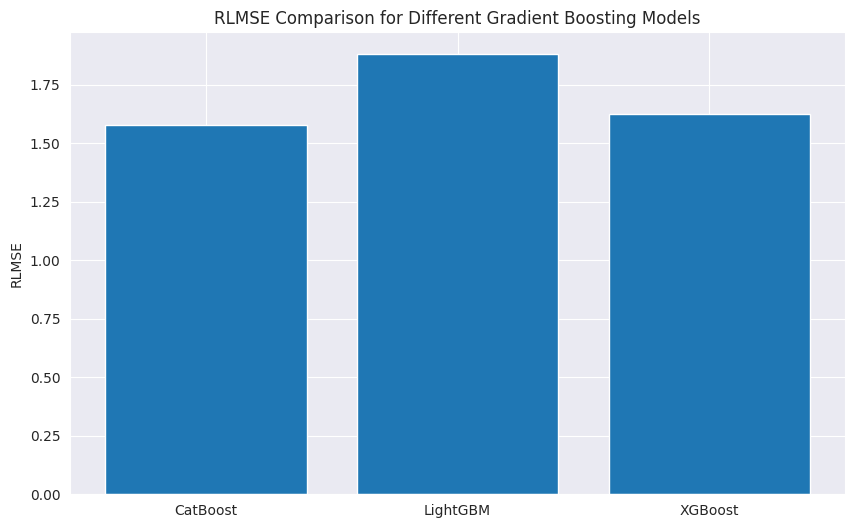

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(['CatBoost', 'LightGBM', 'XGBoost'], [RLMSE(y_test, cat_y_pred).round(3), RLMSE(y_test, lgbm_y_pred).round(3), RLMSE(y_test, xgb_y_pred).round(3)])
plt.title('RLMSE Comparison for Different Gradient Boosting Models')
plt.ylabel('RLMSE')
plt.show()

Из графика видно, что лучше всего с данной задачей справляется CatBoost. Улучшим метрику подобрав к модели параметры (метод gridsearch подбирает параметры очень долго, поэтому пришлось делать это вручную)

In [768]:
cat_model_final = CatBoostRegressor(verbose=0, learning_rate = 0.1, depth = 12, iterations = 1200)

# Обучение модели
cat_model_final.fit(X_train, y_train)

# Предсказание на тестовой выборке
cat_y_pred_final = cat_model_final.predict(X_test)


print("RLMSE_score cat: ", RLMSE(y_test, cat_y_pred_final).round(3))

RLMSE_score cat:  1.294


Сравним 2 результата CatBoost

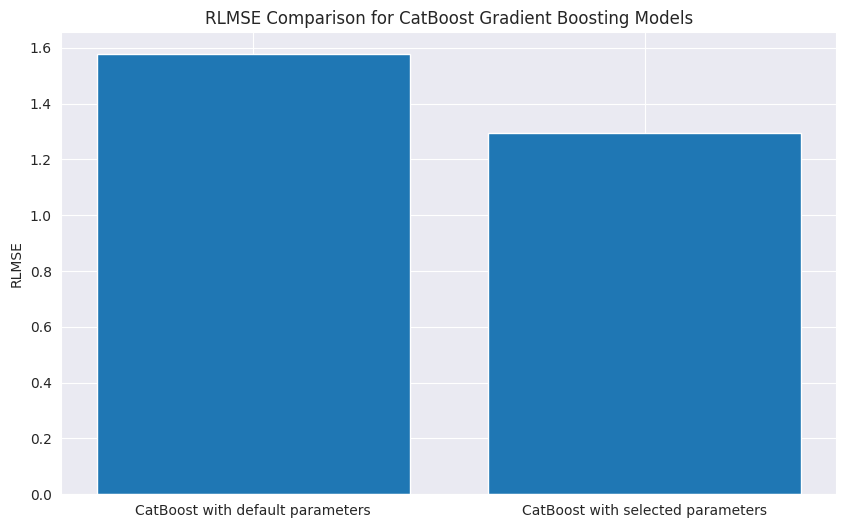

In [770]:
plt.figure(figsize=(10, 6))
plt.bar(['CatBoost with default parameters', 'CatBoost with selected parameters'], [RLMSE(y_test, cat_y_pred).round(3), RLMSE(y_test, cat_y_pred_final).round(3)])
plt.title('RLMSE Comparison for CatBoost Gradient Boosting Models')
plt.ylabel('RLMSE')
plt.show()

Как можно увидеть, метрика CatBoost с подобранными параметрами заметно улучшила качество модели

In [771]:
cat_model_final.save_model('catboost_model_sales.cbm')

# Предсказание продаж

In [772]:
model_1 = CatBoostRegressor()
model_1.load_model('catboost_model_sales.cbm')

In [773]:
df_test_encoded['sales']= model_1.predict(df_test_encoded).round(0)

<ipython-input-773-61e0386e1ba5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_encoded['sales']= model_1.predict(df_test_encoded).round(0)


In [775]:
submission.sample(5)

,id,sales
2060,3002948,0.00
25670,3026558,0.00
16345,3017233,0.00
17727,3018615,0.00
21720,3022608,0.00


In [781]:
predicted_sales_df = submission.merge(df_test_encoded[['id', 'sales']], on='id', how='left').drop(columns = ['sales_x'],axis = 1)
predicted_sales_df.rename(columns={'sales_y': 'sales'}, inplace=True)
predicted_sales_df.sample(5)

,id,sales
18119,3019007,245.00
14701,3015589,61.00
22885,3023773,40.00
24669,3025557,878.00
12412,3013300,12.00


In [783]:
predicted_sales_df.to_csv('/content/drive/My Drive/pred_sales.csv', index=False)

# Итог

Прогнозирование продаж в магазине на основе данных Corporación Favorita, крупного эквадорского розничного продавца продуктов питания, является важной задачей, которая может принести значительные выгоды для бизнеса. Анализ и предсказание продаж позволяют магазинам планировать свои операции, управлять запасами, оптимизировать размещение товаров и ресурсы, а также принимать решения о маркетинговых и рекламных активностях.

Использование различных методов и моделей машинного обучения, таких как градиентный бустинг (XGB, LGBM, CatBoost), позволяет строить прогнозы продаж на основе доступных данных. Эти модели учитывают различные факторы, такие как дата, праздники, тип магазина, рекламные акции и другие, которые могут оказывать влияние на объемы продаж.

Важно отметить, что для достижения точных прогнозов продаж необходимо провести анализ данных, выполнить предобработку, включая обработку пропущенных значений и выбросов, а также выбрать и настроить подходящую модель с учетом специфики данных и целей прогнозирования.

Также стоит учитывать, что прогнозирование продаж является сложной задачей из-за внешних факторов, таких как экономические условия, социальные тенденции и изменения потребительского спроса. Поэтому регулярное обновление и адаптация моделей прогнозирования являются необходимыми для достижения наилучших результатов.

В целом, прогнозирование продаж на основе данных Corporación Favorita позволяет магазинам принимать информированные решения и оптимизировать свою деятельность, что способствует улучшению эффективности и росту бизнеса. 

Что же касается личных исследований, я пришел к выводу, что наиболее эффективная модель машинного обучения - CatBoost. Однако в силу сложности и большого кол-ва данных качество модели несовершенно. На Kaggle значение метрики составляет 1.61 (629 место из 751). Дальнейшие исследования будут связаны с улучшением метрики и подбором более эффективных параметров.

**Проект будет дополняться**